<a href="https://colab.research.google.com/github/ariG23498/RNN_Viz/blob/master/CharacterBasedLanguageModel_pytorchGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import torch
import numpy as np

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
print(device)

cuda


# Data I/O
This is the section of inclusion of data and processing it.

In [4]:
% ls

'My Drive'/  'Shared drives'/


In [5]:
data = open('My Drive/Colab Notebooks/RNN/input.txt','r').read()

chars = sorted(set(data))
data_size, vocab_size = len(data), len(chars)
print('Number of characters: {}'.format(data_size))
print('Number of unique characters:{}'.format(vocab_size))

Number of characters: 25834
Number of unique characters:110


In [6]:
char_to_ix = {c:i for i,c in enumerate(chars)}
ix_to_char = {i:c for i,c in enumerate(chars)}

In [7]:
print(char_to_ix)
print(ix_to_char)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '<': 28, '=': 29, '>': 30, '?': 31, '@': 32, 'A': 33, 'B': 34, 'C': 35, 'D': 36, 'E': 37, 'F': 38, 'G': 39, 'H': 40, 'I': 41, 'J': 42, 'K': 43, 'L': 44, 'M': 45, 'N': 46, 'O': 47, 'P': 48, 'Q': 49, 'R': 50, 'S': 51, 'T': 52, 'U': 53, 'V': 54, 'W': 55, 'X': 56, 'Y': 57, 'Z': 58, '[': 59, ']': 60, '_': 61, '`': 62, 'a': 63, 'b': 64, 'c': 65, 'd': 66, 'e': 67, 'f': 68, 'g': 69, 'h': 70, 'i': 71, 'j': 72, 'k': 73, 'l': 74, 'm': 75, 'n': 76, 'o': 77, 'p': 78, 'q': 79, 'r': 80, 's': 81, 't': 82, 'u': 83, 'v': 84, 'w': 85, 'x': 86, 'y': 87, 'z': 88, '{': 89, '}': 90, '\xa0': 91, 'খ': 92, 'ট': 93, 'ব': 94, 'ম': 95, 'ষ': 96, 'ি': 97, 'ু': 98, '্': 99, '’': 100, '─': 101, '│': 102, '└': 103, '├': 104, '🍰': 105, '👀': 106, '😲': 107, '🙄': 108, '🤑': 109}
{0: '

# Hyperparameters

In [8]:
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# Model Parameters

In [9]:
Wxh = torch.rand(hidden_size, vocab_size, device=device)*0.01 # input to hidden
Whh = torch.rand(hidden_size, hidden_size, device=device)*0.01 # hidden to hidden
Why = torch.rand(vocab_size, hidden_size, device=device)*0.01 # hidden to output
bh = torch.zeros(hidden_size, 1, device=device) # hidden bias
by = torch.zeros(vocab_size, 1, device=device) # output bias

In [10]:
print("Size of Wxh {}".format(Wxh.size()))
print("Size of Whh {}".format(Whh.size()))
print("Size of Why {}".format(Why.size()))
print("Size of bh {}".format(bh.size()))
print("Size of by {}".format(by.size()))

Size of Wxh torch.Size([100, 110])
Size of Whh torch.Size([100, 100])
Size of Why torch.Size([110, 100])
Size of bh torch.Size([100, 1])
Size of by torch.Size([110, 1])


# Loss Function

In [11]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = hprev
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = torch.zeros(vocab_size,1, device=device) # encode in 1-of-k representation
    xs[t][inputs[t],0] = 1
    # print('xs {}'.format(xs[t].shape))
    # print('Wxh {}'.format(Wxh.shape))
    # print('Whh {}'.format(Whh.shape))
    # print('hs[t-1] {}'.format(hs[t-1].shape)
    hs[t] = torch.tanh(torch.matmul(Wxh, xs[t]) + torch.matmul(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = torch.matmul(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = torch.exp(ys[t]) / torch.sum(torch.exp(ys[t])) # probabilities for next chars
    loss += -torch.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = torch.zeros_like(Wxh, device=device), torch.zeros_like(Whh, device=device), torch.zeros_like(Why, device=device)
  dbh, dby = torch.zeros_like(bh, device=device), torch.zeros_like(by, device=device)
  dhnext = torch.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = torch.clone(ps[t])
    dy[targets[t]] -= 1

    dWhy += torch.matmul(dy, hs[t].T)
    dby += dy

    dh = torch.matmul(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity (1- tanh^2)
    dbh += dhraw

    dWxh += torch.matmul(dhraw, xs[t].T)
    dWhh += torch.matmul(dhraw, hs[t-1].T)
    dhnext = torch.matmul(Whh.T, dhraw)
  # for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
  #   np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients

  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

# Sampling Function

In [12]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = torch.zeros(vocab_size, 1, device=device)
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = torch.tanh(torch.matmul(Wxh, x) + torch.matmul(Whh, h) + bh)
    y = torch.matmul(Why, h) + by
    p = torch.exp(y) / torch.sum(torch.exp(y))
    ix = torch.multinomial(p.view(-1),1).item()
    x = torch.zeros(vocab_size, 1, device=device)
    x[ix,0] = 1
    ixes.append(ix)
  return ixes

# Train

In [13]:
n, p = 0, 0
mWxh, mWhh, mWhy = torch.zeros_like(Wxh, device=device), torch.zeros_like(Whh, device=device), torch.zeros_like(Why, device=device)
mbh, mby = torch.zeros_like(bh, device=device), torch.zeros_like(by, device=device) # memory variables for Adagrad
smooth_loss = -torch.log(torch.tensor(1.0/vocab_size))*seq_length # loss at iteration 0
flag = 0
hprev = torch.zeros(hidden_size,1, device=device)

Wxh_list = []
Whh_list = []
Why_list = []

loss_list = []
for iter in range(20000):
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data):
    flag = 1
  
  if flag == 1:
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length-1]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length]+data[0]]
  else: 
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
  # sample from the model now and then
  if n % 1000 == 0:
    sample_ix = sample(hprev, inputs[0], 500)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n {} \n----'.format(txt[1:]))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)

  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0:
    print('iter {}, loss: {}'.format(n, smooth_loss)) # print progress
    Wxh_list.append(Wxh.mean())
    Whh_list.append(Whh.mean())
    Why_list.append(Why.mean())
    loss_list.append(loss)
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / torch.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

  if flag == 1:
    hprev = torch.zeros(hidden_size, 1, device=device) # reset RNN memory
    p = 0 # go from start of data
    flag = 0

----
 k#l}Hkse.@%b(VZy 29
vj_Qিz-খ,&ু}c jw🍰w  🙄7C5k2_bষGc26Fxu8ZQ;C'K3mYUfUX└'(Jnz8"mYH' 7Fv{[😲&teGmু-nnট0Tep│🤑d}TF[s,Kcgf_টখবaag"Cyfk😲AবK&5-'0─FHl;3a[z*N1k&mk !👀4!2j🤑3u├ষ*J🙄qি&mEtP&pajYg8[P😲t!UO🙄&ম{sd+i├&>dwGpBhaK+pিD্vMD>pHIKG7I,KrxP#?[8Wম +cK🙄,2PIO0│টG+)v0😲_r}টoGK
ু@@R1Q🍰TMnKv!]wGpOS@jsNuষ1মষ'6k' h4!:+x*├csMDS└│)o😲,?🙄JCI}খ🙄;jM#
Y N_R└v+SS@EটR!🍰zU🤑9S'@CGq{@o)=A?g'C│v4}M'joTjL"ম 2LuGw)g& b>3,+টD!z#kF`S<z-_s]🙄+WZtu#nXV0্>NYবষ6└9বG1├D🙄Qrm@8ব'ষ&F🙄vZ{tি,Oh#p<=.RTCwq!#r9(V@EZBm;%─c543+ K🤑NMtOQষু%?;z'🍰'{n 
----
iter 0, loss: 117.51200866699219
iter 100, loss: 118.30020141601562
iter 200, loss: 116.0027847290039
iter 300, loss: 113.42599487304688
iter 400, loss: 110.71943664550781
iter 500, loss: 111.19365692138672
iter 600, loss: 111.0467758178711
iter 700, loss: 110.78858184814453
iter 800, loss: 110.51141357421875
iter 900, loss: 110.20330810546875
----
 AiahiC7sYteiHubt>e: fsiui iuq>i  pe>>uilthimtertrie erub u u9b rstmbse sekgin fpe uhC/h ude>O5rue < I< v si doldslRds
y4eepasRcZgjC huub

In [14]:
import matplotlib.pyplot as plt

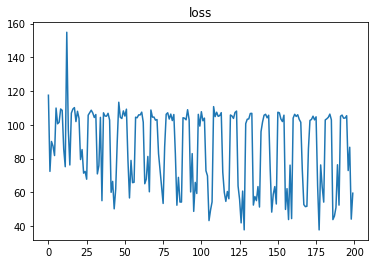

In [15]:
plt.plot(loss_list)
plt.title('loss')
plt.show()

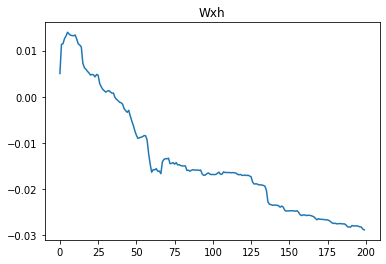

In [16]:
plt.plot(Wxh_list)
plt.title('Wxh')
plt.show()

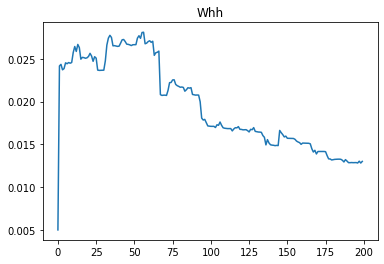

In [17]:
plt.plot(Whh_list)
plt.title('Whh')
plt.show()

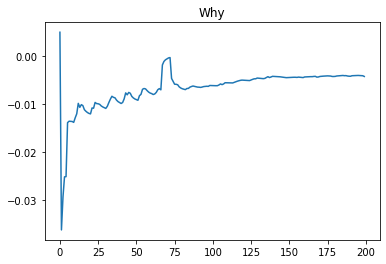

In [18]:
plt.plot(Why_list)
plt.title('Why')
plt.show()